In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from scipy.stats import kstest, norm

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
category_name = pd.read_csv('product_category_name_translation.csv')

### Customers

In [3]:
#Dataframe clients
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
customers.shape

(99441, 5)

In [5]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [6]:
#Affichage des doublons de la colonne customer_id
customers.loc[customers[['customer_id']].duplicated(keep=False),:].sort_values(by='customer_id')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state


On déduit du résultat ci-dessus que toutes les valeurs de customer_id sont différentes

In [7]:
#Affichage des doublons de la colonne customer_unique_id
customers.loc[customers[['customer_unique_id']].duplicated(keep=False),:].sort_values(by='customer_unique_id')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
35608,24b0e2bd287e47d54d193e7bbb51103f,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
19299,1afe8a9c67eec3516c09a8bdcc539090,00172711b30d52eea8b313a7f2cced02,45200,jequie,BA
20023,1b4a75b3478138e99902678254b260f4,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
22066,f6efe5d5c7b85e12355f9d5c3db46da2,004288347e5e88a27ded2bb23747066c,26220,nova iguacu,RJ
72451,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,57055,maceio,AL
...,...,...,...,...,...
75057,1ae563fdfa500d150be6578066d83998,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP
27992,bec0bf00ac5bee64ce8ef5283051a70c,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP
79859,d064be88116eb8b958727aec4cf56a59,ff922bdd6bafcdf99cb90d7f39cea5b3,17340,barra bonita,SP
64323,4b231c90751c27521f7ee27ed2dc3b8f,ffe254cc039740e17dd15a5305035928,37640,extrema,MG


On comprends par le résultat ci-dessus que customer_unique_id associe pour chaque client un unique identifiant. Cependant, pour un même client on pourra avoir plusieurs customer_id (Probablement un pour chaque commande).

Résumé :
- customer_id : Identifiant associé aux couple client/commande
- customer_unique_id : Identifiant unique associé à chaque client
- customer_zip_code_prefix : Code postal du client
- customer_city : Ville du client
- customer_state : Pays du client

In [8]:
x = customers['customer_unique_id'].value_counts() > 1
y = customers[customers['customer_unique_id'].isin(x[x == True].index)].sort_values('customer_unique_id')
z = y.groupby(['customer_unique_id']).nunique()['customer_city']
y[y['customer_unique_id'].isin(z[z>1].index)]

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
91727,483468a56a54dbbbf8f2b2354cc8a729,0178b244a5c281fb2ade54038dd4b161,12518,guaratingueta,SP
57218,ea6ba2b2e27f7efea73bdeab7fd6e4a0,0178b244a5c281fb2ade54038dd4b161,14960,novo horizonte,SP
21682,caded193e8e47b8362864762a83db3c5,08fb46d35bb3ab4037202c23592d1259,13215,jundiai,SP
90484,ebc513ad3aed97e53c11e0e773c10152,08fb46d35bb3ab4037202c23592d1259,3220,sao paulo,SP
87770,a8876ecd91fd22bc8b420c9a4be69955,09d74edf20acb4f9523fb1cf19a18456,34012,nova lima,MG
...,...,...,...,...,...
76055,15baa4d1c9fd174d26e105980d24aeb9,fe3e52de024b82706717c38c8e183084,72306,brasilia,DF
59713,1e79e4f1a4653e041c3ce1ddb2ff239f,fe3e52de024b82706717c38c8e183084,36420,ouro branco,MG
78212,185d4f6e56ea6a1e423468b4d2eaa7cc,fe59d5878cd80080edbd29b5a0a4e1cf,71065,brasilia,DF
23933,94c00589c7550e31350908f68e97d488,fe59d5878cd80080edbd29b5a0a4e1cf,71065,guara,DF


In [9]:
len(z[z>1].index)

122

On observe ci-dessus que 122 clients ont commandés dans différentes villes, il faudra le prendre en compte si on veut leurs attribuer une localisation (en prenant la moyenne de leurs positions par exemple).

### Geolocation

In [10]:
#Dataframe geolocation
geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [11]:
geolocation.shape

(1000163, 5)

In [12]:
geolocation.columns

Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object')

In [13]:
geolocation.nunique()

geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

In [14]:
geolocation['geolocation_zip_code_prefix'].nunique()

19015

Résumé :
- geolocation_zip_code_prefix : Code postal de la géolocalisation
- geolocation_lat : Latitude de la géolocalisation
- geolocation_lng : Longitude de la géolocalisation
- geolocation_city : Ville de la géolocalisation
- geolocation_state : Pays de la géolocalisation

### Items

In [15]:
#Dataframe article vendu
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
items.shape

(112650, 7)

In [17]:
items.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [18]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

Résumé :
- order_id : Identifiant de la commande
- order_item_id : Identifiant de l'article de la commande 
- product_id : Identifiant du produit
- seller_id : Identifiant du vendeur
- shipping_limit_date : Date limite d'expédition
- price : Prix
- freight_value : Valeur du fret

### Payments

In [19]:
#Dataframe paiements/type de paiment
payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [20]:
payments.shape

(103886, 5)

In [21]:
payments.columns

Index(['order_id', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [22]:
payments.nunique()

order_id                99440
payment_sequential         29
payment_type                5
payment_installments       24
payment_value           29077
dtype: int64

Résumé :
- order_id : Identifiant de la commande
- payment_sequential : Paiement successif 
- payment type : Type de paiment
- payment_installments : Versement de paiement 
- payment_value : Valeur de paiment

In [23]:
#On observe le nombre des différents type de paiment
payments['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

On observe que 3 individus ont comme type de paiement 'not_defined'. On décide de remplacer ces valeurs par la valeur la plus fréquente (qui est credit_card)

In [24]:
payments.loc[payments['payment_type'] == 'not_defined', 'payment_type'] = 'credit_card'

### Reviews

In [25]:
#Dataframe avis de commande
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [26]:
reviews.shape

(99224, 7)

In [27]:
reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [28]:
reviews.nunique()

review_id                  98410
order_id                   98673
review_score                   5
review_comment_title        4527
review_comment_message     36159
review_creation_date         636
review_answer_timestamp    98248
dtype: int64

Résumé : 
- review_id : Identifiant de l'avis client
- order_id : Identifiant de la commande
- review_score : Note laissé par le client
- review_comment_title : Titre du commentaire client
- review_comment_message : Commentaire client
- review_creation_date : Date de création du commentaire
- review_answer_timestamp : Date de la réponse

### Orders

In [29]:
#Dataframe commandes
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [30]:
orders.shape

(99441, 8)

In [31]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [32]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [33]:
orders['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [34]:
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [35]:
#Changement des types des colonnes concernées
orders = orders.astype({'order_approved_at' : 'datetime64[ns]',
              'order_delivered_carrier_date' : 'datetime64[ns]',
              'order_delivered_customer_date' : 'datetime64[ns]',
              'order_estimated_delivery_date' : 'datetime64[ns]'})

Résumé :
- order_id : Identifiant de la commande
- customer_id : Identifiant client
- order_status : Statut de la commande
- order_purchase_timestamp : Heure d'achat de la commande
- order_approved_at : Heure à laquelle la commande a été approuvée
- order_delivered_carrier_date : Date de livraison au transporteur
- order_delivered_customer_date : Date de livraison au client
- order_estimated_delivery_date : Date estimée de livraison

In [36]:
orders.isna().mean()

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.001609
order_delivered_carrier_date     0.017930
order_delivered_customer_date    0.029817
order_estimated_delivery_date    0.000000
dtype: float64

On observe qu'environ 3% des commandes n'ont pas de date de livraison au client enregistré. On décide de les supprimés car elles possèdent pour beaucoup essentiellement des données manquantes (Comme on peut le voir ci-dessous).

In [37]:
#Proportion de données manquantes pour les commandes n'ayant pas de date de livraison
orders[orders['order_delivered_customer_date'].isna()].isna().mean()

order_id                         0.000000
customer_id                      0.000000
order_status                     0.000000
order_purchase_timestamp         0.000000
order_approved_at                0.049241
order_delivered_carrier_date     0.601012
order_delivered_customer_date    1.000000
order_estimated_delivery_date    0.000000
dtype: float64

In [38]:
#Suppression des données manquantes
orders.drop(orders[orders['order_delivered_customer_date'].isna()].index, inplace=True)

### Products

In [39]:
#Dataframe des produits
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [40]:
products.shape

(32951, 9)

In [41]:
products.columns

Index(['product_id', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],
      dtype='object')

In [42]:
products.nunique()

product_id                    32951
product_category_name            73
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
product_weight_g               2204
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64

Résumé :
- product_id : Identifiant du produit
- product_category_name : Nom de la catégorie du produit
- product_name_lenght : Longueur du nom du produit
- product_description_lenght : Longueur de la description du produit
- product_photos_qty : Nombre de photos du produit
- product_weight_g : Poids du produit (en g)
- product_length_cm : Longueur du produit (en cm)
- product_height_cm : Hauteur du produit (en cm)
- product_width_cm : Largeur du produit (en cm)

### Sellers

In [43]:
#Dataframe vendeurs
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [44]:
sellers.shape

(3095, 4)

In [45]:
sellers.columns

Index(['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state'], dtype='object')

In [46]:
sellers.nunique()

seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64

Résumé :
- seller_id : Identifiant du vendeur
- seller_zip_code_prefix : Code postal du vendeur
- seller_city : Ville du vendeur
- seller_state : Etat du vendeur

### Category name

In [47]:
#Traduction du nom de la catégorie des produits
category_name.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [48]:
category_name.shape

(71, 2)

In [49]:
category_name.columns

Index(['product_category_name', 'product_category_name_english'], dtype='object')

In [50]:
category_name.nunique()

product_category_name            71
product_category_name_english    71
dtype: int64

Résumé :
- product_category_name : Nom de la catégorie du produit (en portugais)
- product_category_name_english : Nom de la catégorie du produit (en anglais)

## RFM (Récense Fréquence Montant)

In [51]:
#On convertit 'order_purchase_timestamp' au format date
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors = 'coerce')

In [52]:
#Création de la variable recense
jointure = pd.merge(customers, orders, on='customer_id')
recense = jointure[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').max().rename(columns={
    'order_purchase_timestamp':'last_purchase'
})

nb_days_last_order = recense['last_purchase'].dt.date.max() - recense['last_purchase'].dt.date 

recense = nb_days_last_order.apply(lambda x : x.days)

recense = recense + 1

In [53]:
#Création de la variable frequence
frequence = customers[['customer_unique_id', 'customer_id']].groupby('customer_unique_id').count().rename(columns={'customer_id':'number_orders'})

In [54]:
#Création de la variable montant
jointure_2 = pd.merge(jointure, payments, on='order_id')
montant = jointure_2[['customer_unique_id', 'payment_value']].groupby('customer_unique_id').sum().rename(columns={'payment_value':'payment_total'})

In [55]:
#Création de RFM
rfm = pd.merge(recense, frequence, left_index=True, right_index=True).merge(montant, left_index=True, right_index=True)

## Feature Engineering

In [56]:
#Review score moyen
jointure_3 = pd.merge(jointure, reviews, on='order_id')
review_score_mean = jointure_3.groupby('customer_unique_id').mean()['review_score']
review_score_mean = review_score_mean.reset_index()

In [57]:
#Temps d'attente moyen entre l'achat et la réception
orders['days_of_waiting'] = orders['order_delivered_customer_date'].dt.date - orders['order_purchase_timestamp'].dt.date 
orders['days_of_waiting'] = orders['days_of_waiting'].apply(lambda x : x.days)
jointure_bis = pd.merge(customers, orders, on='customer_id')
waiting = jointure_bis.groupby('customer_unique_id').mean()['days_of_waiting']
waiting = waiting.reset_index()
waiting['days_of_waiting'] = waiting['days_of_waiting'] + 1

In [58]:
#Temps d'attente moyen entre la date prévue et la date de réception
orders['days_of_waiting_2'] = orders['order_delivered_customer_date'].dt.date - orders['order_estimated_delivery_date'].dt.date
orders['days_of_waiting_2'] = orders['days_of_waiting_2'].apply(lambda x : x.days)
jointure_bis_2 = pd.merge(customers, orders, on='customer_id')
waiting_2 = jointure_bis_2.groupby('customer_unique_id').mean()['days_of_waiting_2']
waiting_2 = waiting_2.reset_index()

In [59]:
#Localisation des individus 
loc_mean = geolocation.groupby('geolocation_city').mean()[['geolocation_lat', 'geolocation_lng']].reset_index()
join = pd.merge(customers, loc_mean, left_on='customer_city', right_on='geolocation_city')
coordinates = join.groupby('customer_unique_id').mean()[['geolocation_lat', 'geolocation_lng']]
coordinates = coordinates.reset_index()

In [60]:
#Rapport du fret par le prix
items['freight_by_price'] = items['freight_value'] / items['price']
join_2 = pd.merge(jointure, items, on='order_id')
freight_by_price = join_2.groupby('customer_unique_id').mean()['freight_by_price']
freight_by_price = freight_by_price.reset_index()

In [61]:
#Moyenne du nombre d'article par commande
item_per_order = items[['order_id', 'order_item_id']].groupby('order_id').max().reset_index()
join_3 = pd.merge(jointure, item_per_order, on='order_id')
mean_item_per_order = join_3.groupby('customer_unique_id').mean()['order_item_id']
mean_item_per_order = mean_item_per_order.reset_index().rename(columns={'order_item_id':'mean_item_per_order'})

In [62]:
#Tous les types de paiements utilisés par les clients
payment_type = payments.merge(pd.get_dummies(payments['payment_type'], dtype=float), left_index=True, right_index=True).groupby('order_id').sum()[['boleto', 'credit_card', 'debit_card', 'voucher']]
join_4 = jointure.merge(payment_type, on='order_id')
type_by_customer = join_4.groupby('customer_unique_id').sum().drop('customer_zip_code_prefix', axis=1)
for payment in type_by_customer.columns:
    type_by_customer[payment] = type_by_customer[payment].apply(lambda x: 1 if x > 1 else x)
type_by_customer = type_by_customer.reset_index()

In [63]:
#Distance moyenne entre chaque clients et ses vendeurs
join_5 = pd.merge(sellers, loc_mean, left_on='seller_city', right_on='geolocation_city')
coordinates_2 = join_5.groupby('seller_id').mean()[['geolocation_lat', 'geolocation_lng']]
j1 = jointure.merge(coordinates.reset_index(), on='customer_unique_id')
j2 = items.merge(coordinates_2.reset_index(), on='seller_id')
coor_cust_sell = j1.merge(j2, on='order_id')[['customer_unique_id', 'seller_id', 'geolocation_lat_x', 'geolocation_lng_x', 
                             'geolocation_lat_y', 'geolocation_lng_y']].rename(columns={
                                                                         'geolocation_lat_x' : 'geo_lat_cust',
                                                                         'geolocation_lng_x' : 'geo_lng_cust',
                                                                         'geolocation_lat_y' : 'geo_lat_sell',
                                                                         'geolocation_lng_y' : 'geo_lng_sell'})
coor_cust_sell['distance_bet_cust_n_sell'] = np.sqrt((coor_cust_sell['geo_lat_cust'] - coor_cust_sell['geo_lat_sell'])**2 + (coor_cust_sell['geo_lng_cust'] - coor_cust_sell['geo_lng_sell'])**2)
dist_bet_cust_n_sell = coor_cust_sell.groupby('customer_unique_id').mean()
dist_bet_cust_n_sell = dist_bet_cust_n_sell.reset_index()
dist_bet_cust_n_sell.drop(['geo_lat_cust', 'geo_lng_cust', 'geo_lat_sell', 'geo_lng_sell'], axis=1, inplace=True)

In [64]:
new_data = review_score_mean.merge(waiting, 
                        on='customer_unique_id').merge(waiting_2, 
                        on='customer_unique_id').merge(coordinates, 
                        on='customer_unique_id').merge(freight_by_price,
                        on='customer_unique_id').merge(mean_item_per_order,
                        on='customer_unique_id').merge(type_by_customer,
                        on='customer_unique_id').merge(dist_bet_cust_n_sell,
                        on='customer_unique_id')

Avant qu'on fasse la jointure, on avait 2997 clients ayant fait plus de 2 commandes (Ceux-ci nous intéresse particulièrement).

In [65]:
cus = customers.groupby('customer_unique_id').count()['customer_id']
len(cus[cus > 1].index)

2997

Après avoir fait la jointure on se retrouve à 2956. On en a donc perdu 41. Cela reste négligeable au vue du nombre de clients restant.

In [66]:
new_data[new_data['customer_unique_id'].isin(cus[cus > 1].index)].shape[0]

2956

## Analyse de RFM

In [67]:
from scipy.stats import shapiro

### Univariée

In [68]:
rfm['last_purchase'].describe()

count    93355.000000
mean       238.505843
std        152.617650
min          1.000000
25%        115.000000
50%        220.000000
75%        347.000000
max        696.000000
Name: last_purchase, dtype: float64

<AxesSubplot:xlabel='last_purchase', ylabel='Count'>

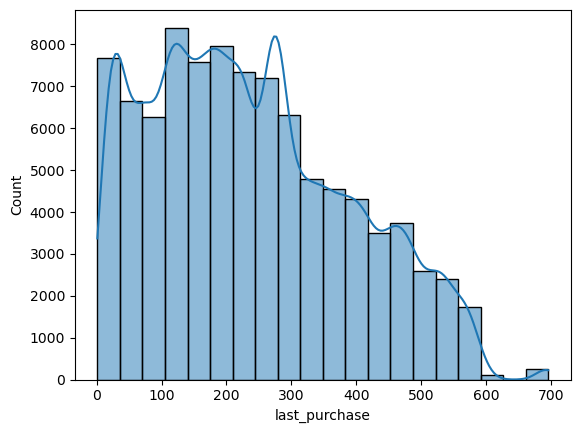

In [69]:
sns.histplot(data=rfm, x="last_purchase", bins=20, kde=True)

<AxesSubplot:xlabel='last_purchase'>

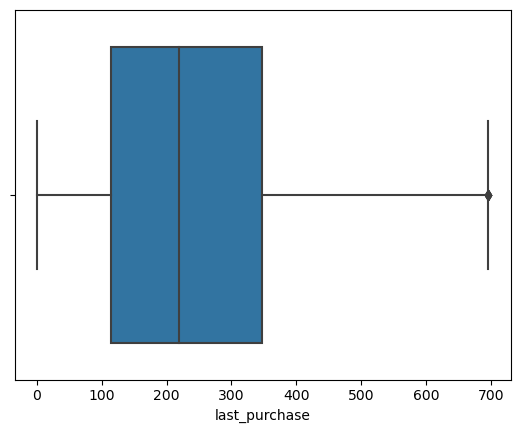

In [70]:
sns.boxplot(data=rfm, x="last_purchase")

In [71]:
shapiro(rfm['last_purchase'])

C:\Users\moham\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9614532589912415, pvalue=0.0)

La p-value étant égale à 0 (<0.05) alors on rejete l'hypothèse nulle. C'est à dire qu'on a suffisamment de preuve pour dire que l'échantillon n'est pas issus d'une distribution normale.

In [72]:
rfm['orders'] = 0
rfm.loc[rfm['number_orders'] == 1, 'orders'] = 'A commandé une fois'
rfm.loc[rfm['number_orders'] != 1, 'orders'] = 'A commandé plusieurs fois'

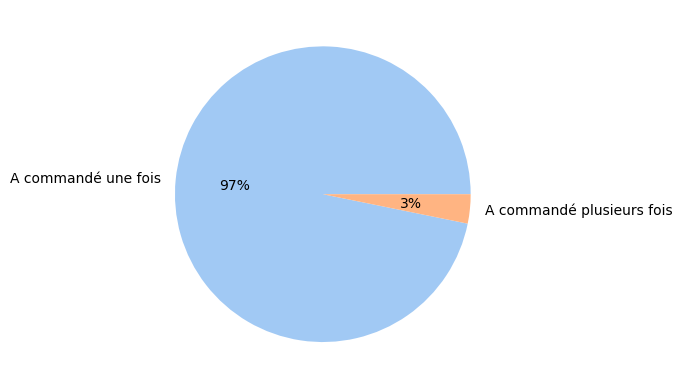

In [73]:
#define data
data = rfm['orders'].value_counts(normalize=True).values
labels = ['A commandé une fois', 'A commandé plusieurs fois']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:2]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

<AxesSubplot:xlabel='payment_total', ylabel='Count'>

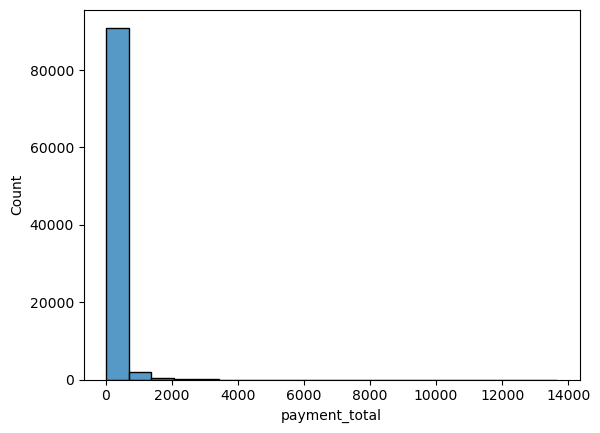

In [74]:
sns.histplot(data=rfm, x='payment_total', bins=20)

On observe que la distribution de payment_total est très concentrée à gauche. On veut voir ce que donnerait ce même histogramme en échelle logarithmique.

<AxesSubplot:xlabel='payment_total', ylabel='Count'>

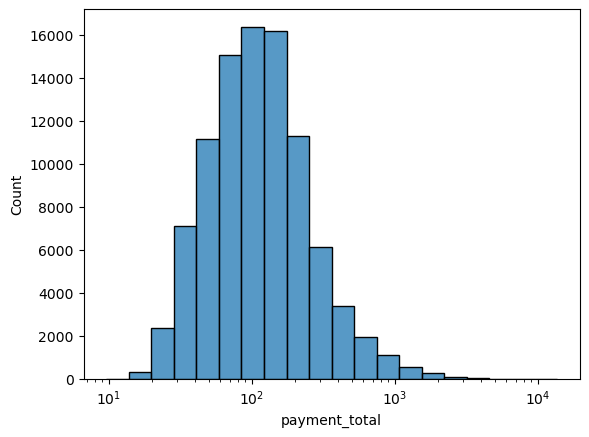

In [75]:
sns.histplot(data=rfm, x='payment_total', bins=20, log_scale=True)

On voit ici clairement que la distribution tends vers une loi normale. Vérifions le en effectuant le test de Kolmogorov-Smirnov.

In [76]:
# Test de Kolmogorov-Smirnov
statistic, p_value = kstest(list(np.log10(rfm[rfm['payment_total'] != 0]['payment_total'].values)), norm.cdf)
print("Statistique de test :", statistic)
print("Valeur p :", p_value)

Statistique de test : 0.9041657093345767
Valeur p : 0.0


In [77]:
# Test de Kolmogorov-Smirnov
statistic, p_value = kstest(list(rfm[rfm['last_purchase'] != 0]['payment_total'].values), norm.cdf)
print("Statistique de test :", statistic)
print("Valeur p :", p_value)

Statistique de test : 1.0
Valeur p : 0.0


Ici aussi on trouve une p-value égale à 0 (<0.05). On rejete alors l'hypothèse nulle. C'est à dire qu'on a suffisamment de preuve pour dire que l'échantillon n'est pas issus d'une distribution normale. Cependant, comme elle 

In [78]:
# Création de l'objet scaler
scaler = StandardScaler()

# Normalisation des données numériques
data_scaled = scaler.fit_transform(rfm[['last_purchase', 'number_orders', 'payment_total']])

In [79]:
rfm_scaled = pd.DataFrame(data_scaled).rename(columns={0:rfm.columns[0],
                                         1:rfm.columns[1],
                                         2:rfm.columns[2]}).join(pd.DataFrame(rfm['orders'].values).rename(columns=
                                                                                                          {0:rfm.columns[3]}))
rfm_scaled.set_index(rfm.index, inplace=True)

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='payment_total', ylabel='Count'>

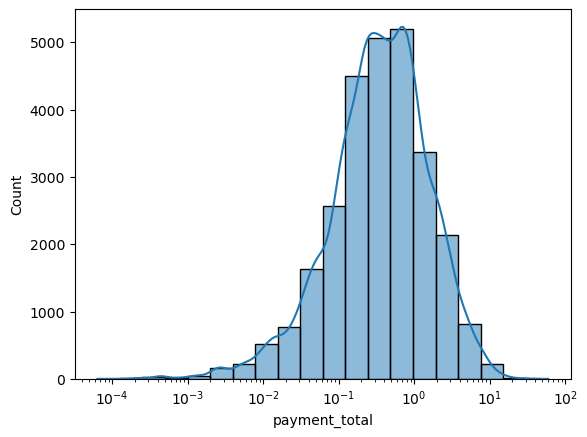

In [80]:
sns.histplot(data=rfm_scaled, x='payment_total', bins=20, kde=True, log_scale=True)

## Analyse bivariée

In [81]:
rfm.corr()

,last_purchase,number_orders,payment_total
last_purchase,1.000000,-0.021309,-0.004405
number_orders,-0.021309,1.000000,0.120785
payment_total,-0.004405,0.120785,1.000000


<AxesSubplot:xlabel='last_purchase', ylabel='orders'>

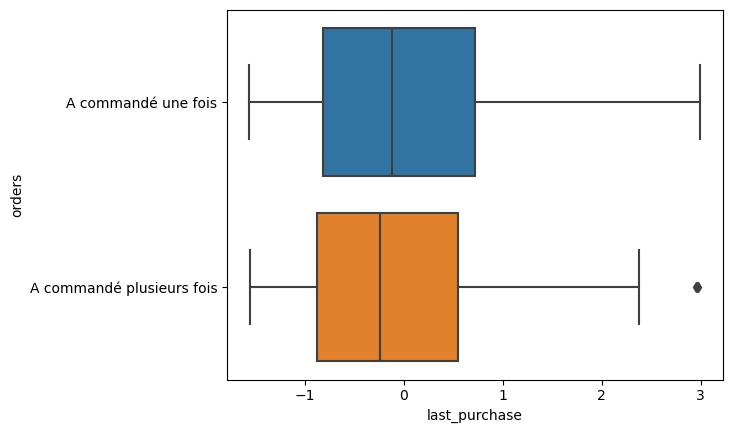

In [82]:
sns.boxplot(data=rfm_scaled, x='last_purchase', y='orders')

<AxesSubplot:xlabel='payment_total', ylabel='orders'>

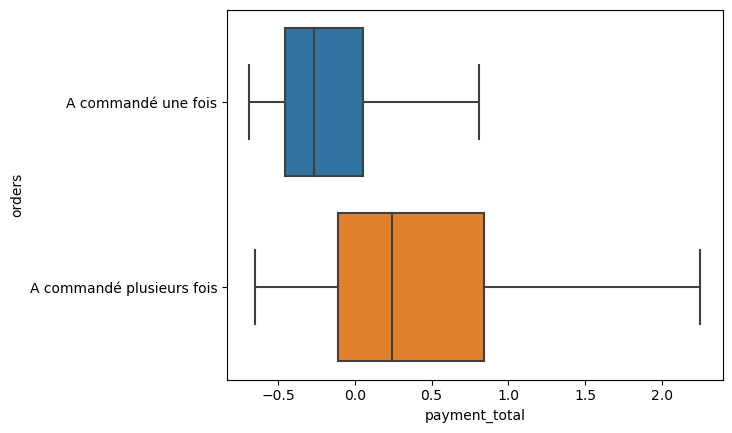

In [83]:
sns.boxplot(data=rfm_scaled, x='payment_total', y='orders', showfliers = False)

## Analyse Multivariée

In [84]:
from sklearn.decomposition import PCA

In [85]:
X = rfm_scaled[['last_purchase', 'number_orders', 'payment_total']]

In [86]:
pca = PCA(n_components=2)

#On produit un ACP sur les données normalisées
pca.fit(X)

PCA(n_components=2)

In [87]:
#Combien de variance est expliquée par chacun de nos 2 axes ?
pca.explained_variance_ratio_

array([0.37449171, 0.33283146])

In [88]:
#fonction pour le graphe de corrélation
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [89]:
#fonction pour afficher les projections des variables dans R^n 
def display_factorial_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()


In [90]:
pcs = pca.components_ 
pcs = pd.DataFrame(pcs)
pcs.columns = X.columns
pcs.index = [f"F{i}" for i in range(1,3)]
pcs.round(2)

,last_purchase,number_orders,payment_total
F1,-0.15,0.70,0.69
F2,0.98,0.03,0.17


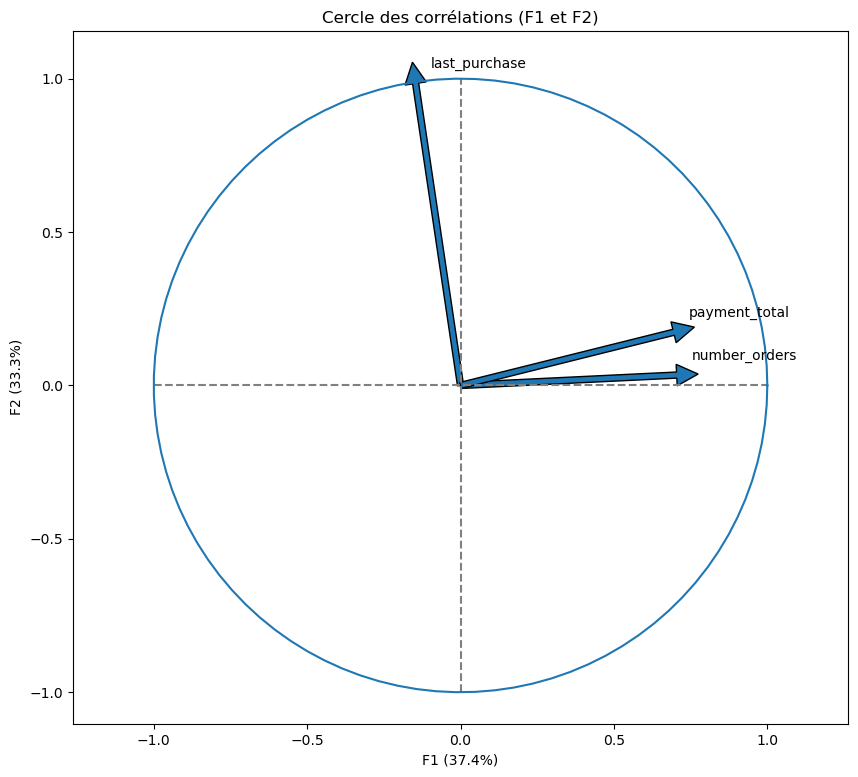

In [91]:
#On affiche le cercle de corrélation
x_y = (0,1)
correlation_graph(pca, x_y, pcs.columns)

In [92]:
#Projection des variables 
X_proj = pca.transform(X)

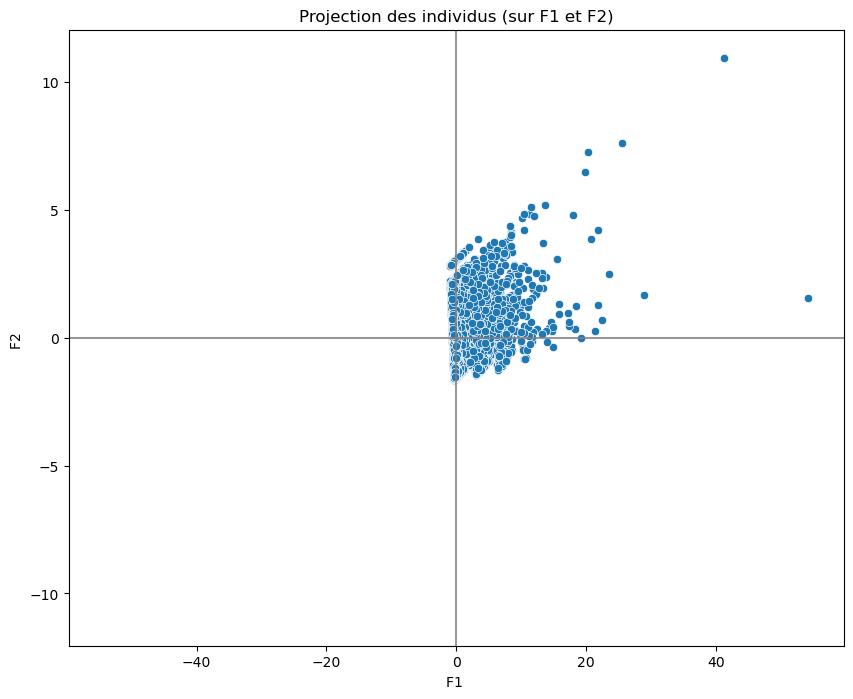

In [93]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y)

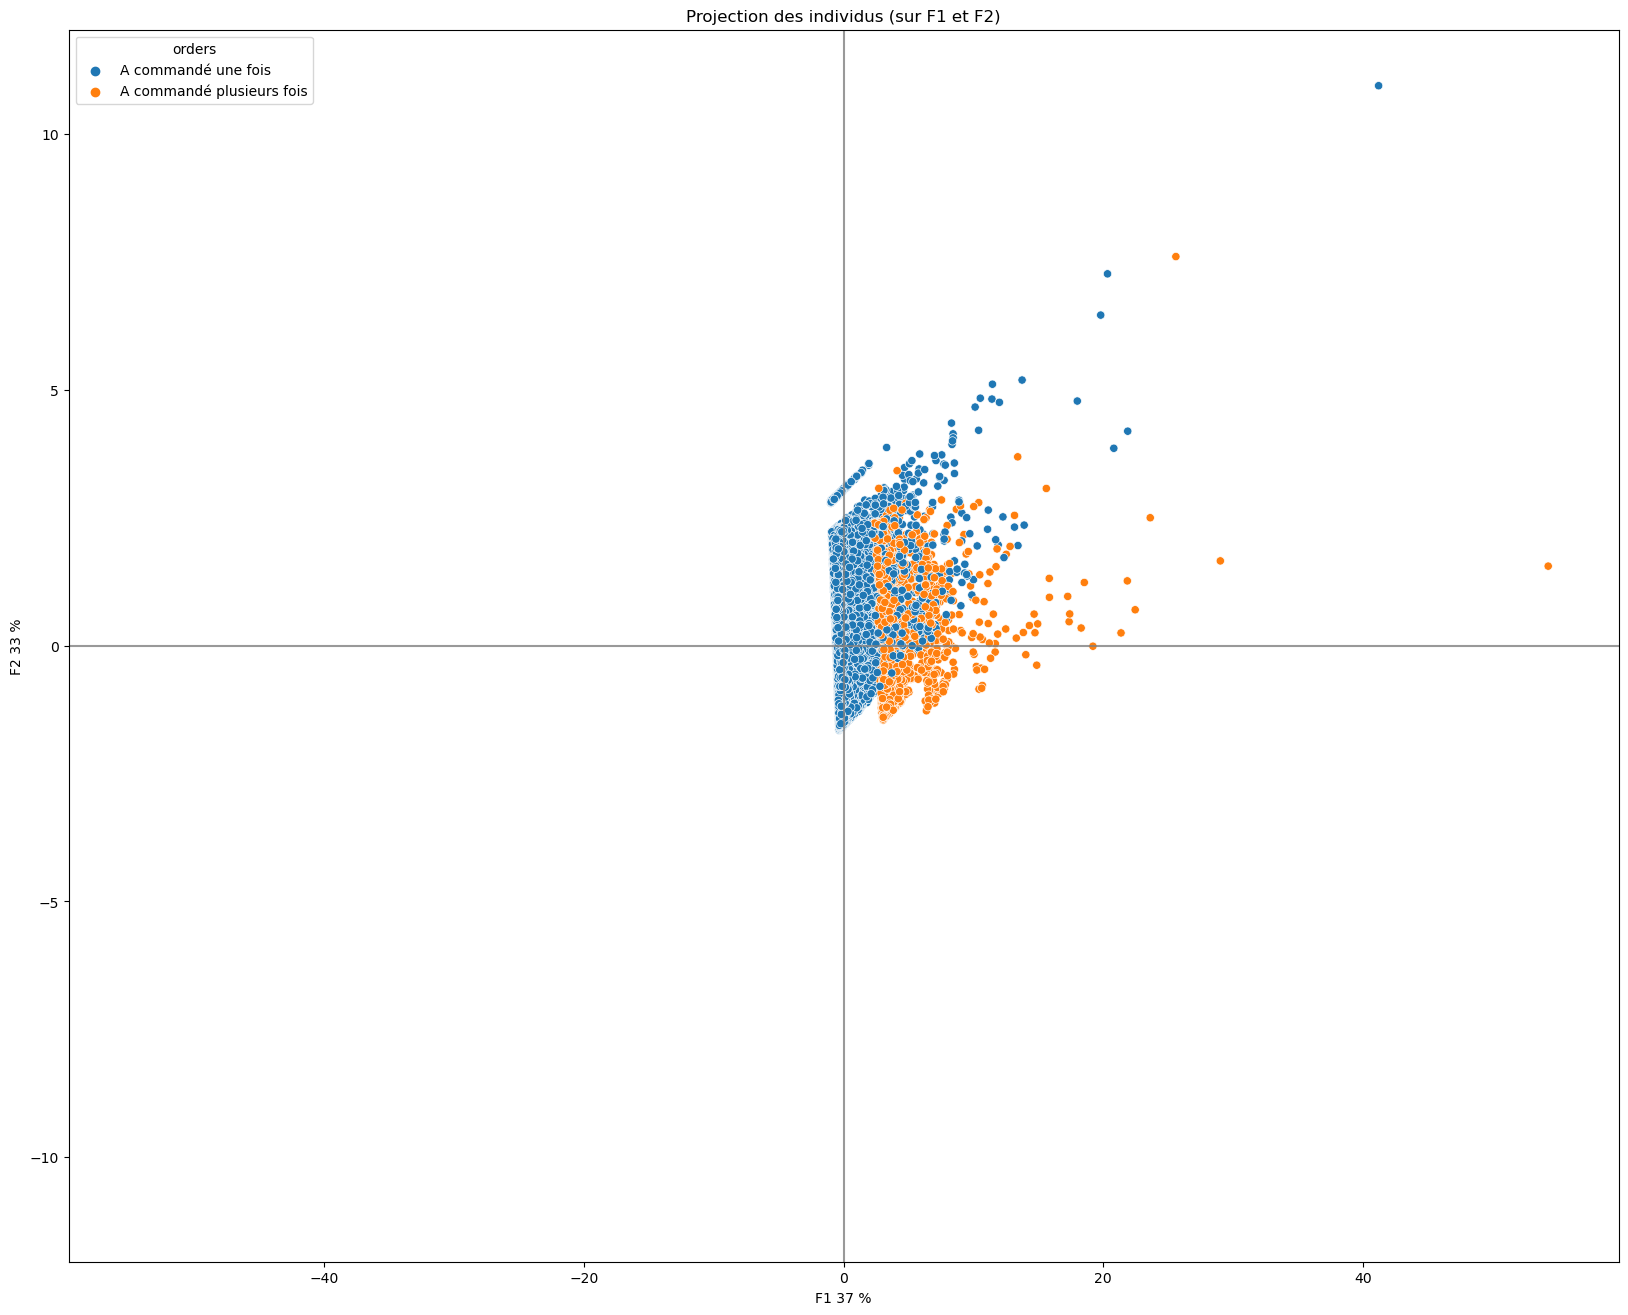

In [94]:
[0,1]
display_factorial_planes(X_proj, x_y, pca, figsize=(20,16), marker="o", clusters=rfm_scaled['orders'])

# Analyse des autres variables

## Analyse Univariée

### Review Score Moyen

<AxesSubplot:xlabel='review_score', ylabel='Count'>

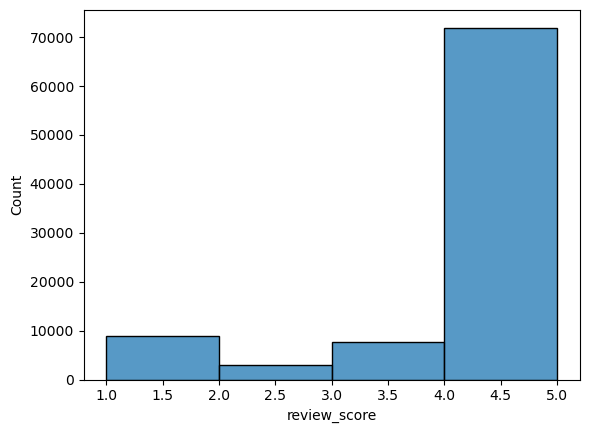

In [95]:
sns.histplot(data=new_data, x='review_score', bins=4)

En observant le graphique ci-dessus on se rends compte qu'il y a une grande majorité de bonnes notes (entre 4 et 5). Quantifions ce nombre :

In [96]:
new_data['note'] = 0
new_data.loc[new_data['review_score'] >= 4, 'note'] = 'Bonne note'
new_data.loc[new_data['review_score'] < 4, 'note'] = 'Mauvaise note'

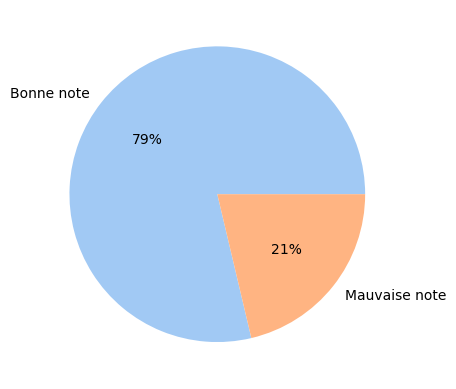

In [97]:
#define data
data = new_data['note'].value_counts(normalize=True).values
labels = ['Bonne note', 'Mauvaise note']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:2]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

On a donc 79% de note supérieure ou égale à 4 contre 21% de note strictement inférieure à 4.

### Temps d'attente moyen entre la date d'achat et la date de réception

<AxesSubplot:xlabel='days_of_waiting', ylabel='Count'>

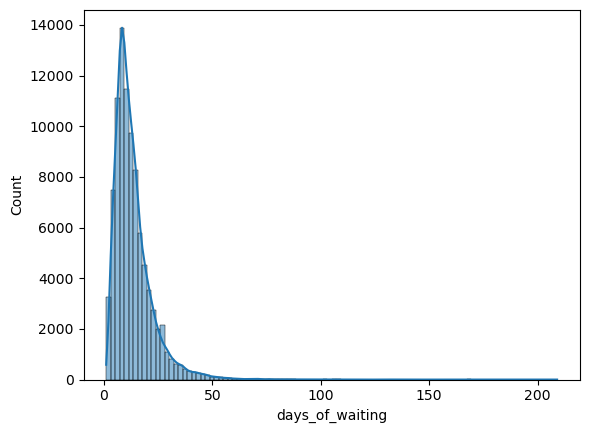

In [98]:
sns.histplot(data=new_data, x='days_of_waiting', bins=100, kde=True)

Lorsqu'on passe à l'échelle logarithmique on remarque que le temps d'attente suit une distribution qui tends vers une loi normale.

<AxesSubplot:xlabel='days_of_waiting', ylabel='Count'>

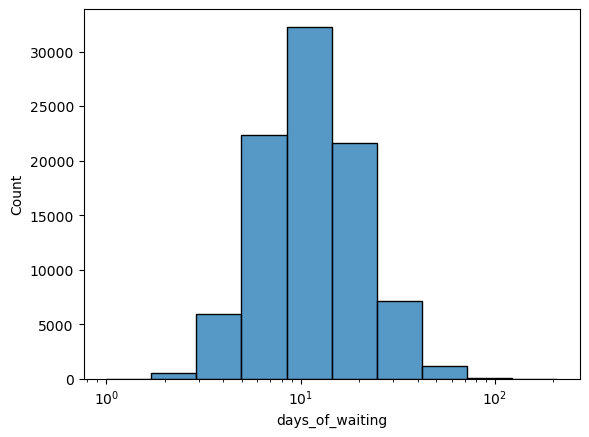

In [99]:
sns.histplot(data=new_data, x='days_of_waiting', bins=10, log_scale=True)

### Temps d'attente moyen entre la date prévue et la date de livraison

<AxesSubplot:xlabel='days_of_waiting_2', ylabel='Count'>

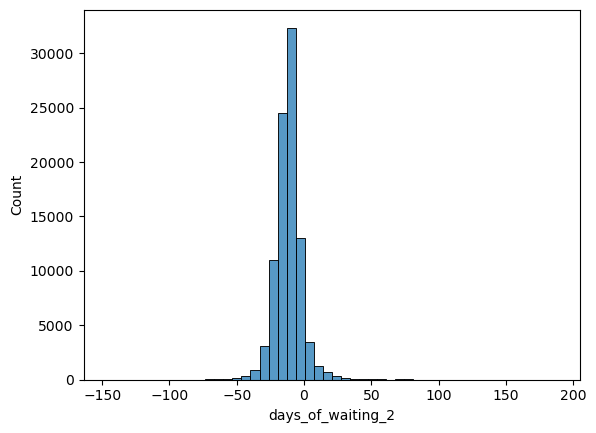

In [100]:
sns.histplot(data=new_data, x='days_of_waiting_2', bins=50)

Ici aussi on remarque que la distribution tends vers une loi normale. On observe de plus qu'une grande proportion des clients a plutôt eut de l'avance entre la date estimée et la date effective. On veut voir le nombre de client ayant eut du retard dans leurs commandes et ceux ayant eut de l'avance.

In [101]:
new_data['early_or_late'] = 0
new_data.loc[new_data['days_of_waiting_2'] > 0, 'early_or_late'] = 'Retard'
new_data.loc[new_data['days_of_waiting_2'] <= 0, 'early_or_late'] = 'En avance'

In [102]:
new_data['early_or_late'].value_counts()

En avance    85354
Retard        6066
Name: early_or_late, dtype: int64

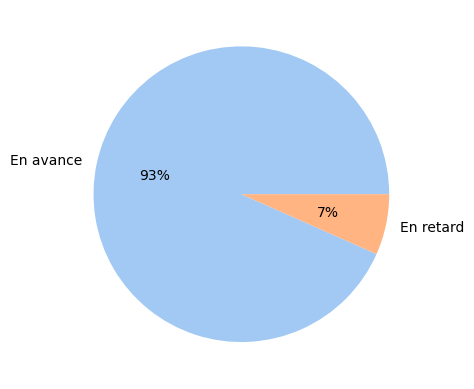

In [103]:
#define data
data = new_data['early_or_late'].value_counts(normalize=True).values
labels = ['En avance', 'En retard']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:2]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

On a donc 93% des clients ayant eut un temps d'attente moyen inférieur au temps d'attente prévu. 7% des clients ont eut du retard entre la date prévue et la date de livraison.

### Geolocalisation

<AxesSubplot:xlabel='geolocation_lng', ylabel='geolocation_lat'>

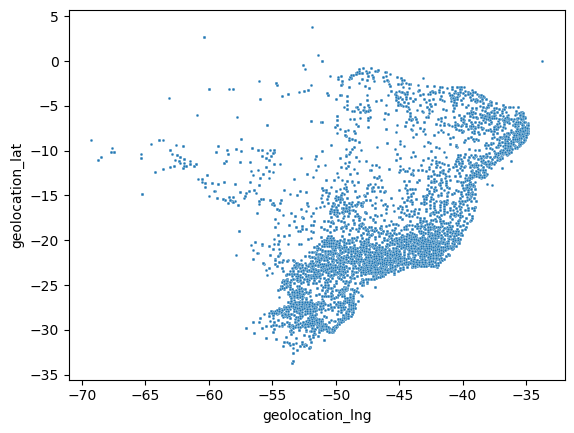

In [104]:
sns.scatterplot(x='geolocation_lng', y='geolocation_lat', data=new_data.loc[(new_data.geolocation_lat<5) & (new_data.geolocation_lng<-30)],
                s=4)

On observe que les clients se situent plutôt vers la côte du brésil avec une grosse concentration de clients se situant dans la région de Rio de Janeiro.

### Rapport Frêt / Prix 

Le rapport frêt/prix peut être intéressant à étudier, en effet d'un point de vue comportemental on s'imagine facilement qu'un rapport frêt/prix très petit est satisfaisant pour un client tandis que l'inverse peut être problématique.

In [105]:
new_data['freight_by_price'].describe()

count    91420.000000
mean         0.308850
std          0.312682
min          0.000000
25%          0.132842
50%          0.225316
75%          0.381892
max         21.447059
Name: freight_by_price, dtype: float64

<AxesSubplot:xlabel='freight_by_price'>

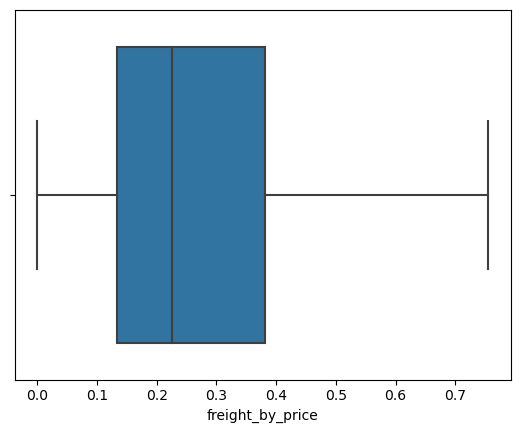

In [106]:
sns.boxplot(data=new_data, x='freight_by_price', showfliers=False)

On observe qu'au moins 75% des rapports frêt/prix sont inférieur à 0.4 (ce qui est intéressant pour le client).

### Moyenne du nombe d'article par commande (par client)

In [107]:
new_data['mean_item_per_order'].describe()

count    91420.000000
mean         1.138578
std          0.521715
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         21.000000
Name: mean_item_per_order, dtype: float64

On observe qu'une grande partit des clients commande en moyenne 1 article par commande (au moins 75%)

<AxesSubplot:xlabel='mean_item_per_order', ylabel='Count'>

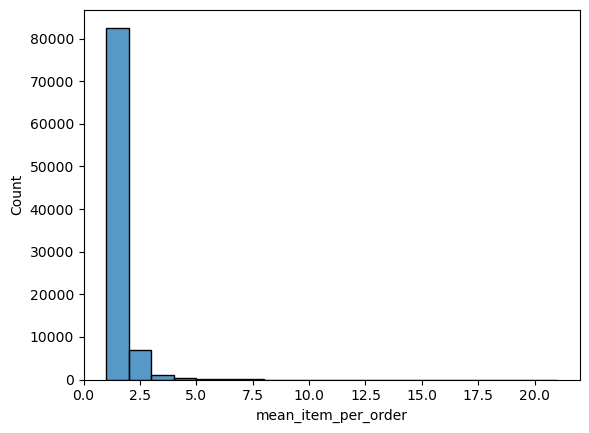

In [108]:
sns.histplot(data=new_data, x='mean_item_per_order', bins=20)

### Type de paiement

In [109]:
utilisation_frequency = new_data[['boleto', 'credit_card', 'debit_card', 'voucher']].sum(axis=0)/new_data[['boleto', 'credit_card', 'debit_card', 'voucher']].sum().sum()

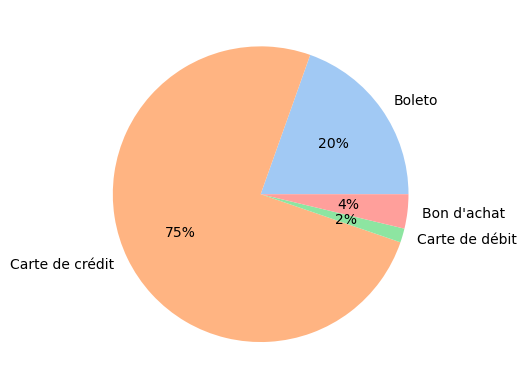

In [110]:
#define data
data = utilisation_frequency.values
labels = ["Boleto", "Carte de crédit", "Carte de débit", "Bon d'achat"]

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:4]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

On observe que le type de paiement le plus fréquent (à 75%) se trouve être la carte de crédit. On a ensuite le Boleto (avec 20% d'utilisation) et enfin les bons d'achats (4%) suivit de près par la carte de débit (2%).

### Distance entre le client et le vendeur

In [111]:
new_data['distance_bet_cust_n_sell'].describe()

count    91420.000000
mean         5.570465
std          5.372174
min          0.000000
25%          1.799146
50%          4.113237
75%          7.419060
max         79.598767
Name: distance_bet_cust_n_sell, dtype: float64

<AxesSubplot:xlabel='distance_bet_cust_n_sell', ylabel='Count'>

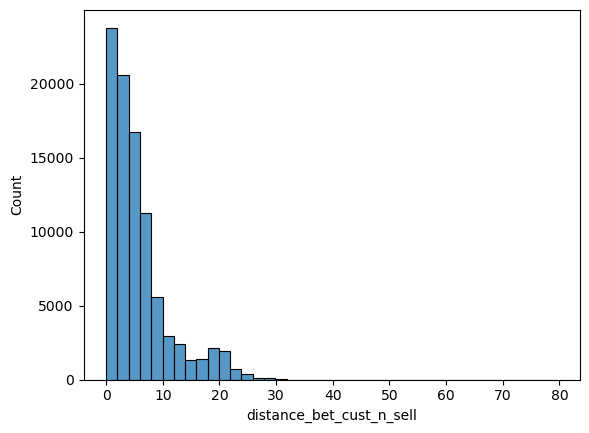

In [112]:
sns.histplot(data=new_data, x='distance_bet_cust_n_sell', bins=40)

On observe que plus la distance augmente, plus la proportion d'individu baisse. On interprète cela en disant que le commerce à plutôt tendance à ce faire entre personne ayant une grande proximité géographique.

## Analyse Bivariée

### Fusion de new_data et rfm

In [113]:
data_base = new_data.set_index('customer_unique_id').merge(rfm, left_index=True, right_index=True).drop(['note', 'early_or_late', 'orders'], axis=1)

### Normalisation du dataframe

In [114]:
# Création de l'objet scaler
scaler = StandardScaler()

# Normalisation des données numériques
data_base_scaled = scaler.fit_transform(data_base)

In [115]:
df = pd.DataFrame(data_base_scaled, columns=data_base.columns).set_index(data_base.index, data_base.index.name)

C:\Users\moham\AppData\Local\Temp\ipykernel_2812\1020797356.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.set_index except for the argument 'keys' will be keyword-only.
  df = pd.DataFrame(data_base_scaled, columns=data_base.columns).set_index(data_base.index, data_base.index.name)


### Analyse

<AxesSubplot:>

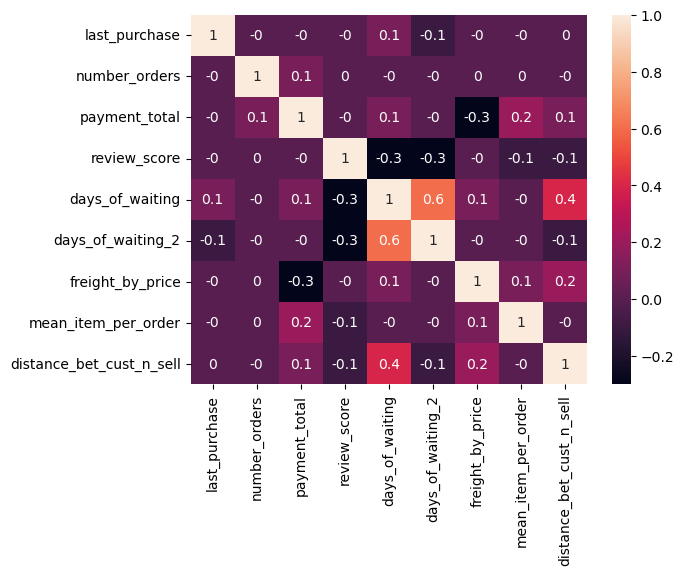

In [116]:
#Tableau des corrélations
sns.heatmap(np.round(df[['last_purchase', 'number_orders', 'payment_total', 'review_score', 'days_of_waiting', 'days_of_waiting_2',
   'freight_by_price', 'mean_item_per_order', 'distance_bet_cust_n_sell']].corr(), 1), annot=True)

On observe de légères corrélations : 
- Plus le montant total de paiement sur le site est élevé, plus le ratio fret/prix est petit (donc est avantageux pour le client)
- Plus le temps d'attente (attendu et absolu) est petit, plus la note moyenne mise par le client est élevée : C'est donc un facteur pertinent d'amélioration
- Le temps d'attente est directement corélé à la distance entre le client et le vendeur
- Plus la distance entre le vendeur et le client est grande plus le rapport fret/prix est élevé (donc désaventageux pour le client)

In [117]:
#Coefficients de variation
data_base[['review_score', 'days_of_waiting', 'freight_by_price', 'mean_item_per_order', 
    'distance_bet_cust_n_sell', 'last_purchase', 'number_orders', 'payment_total', ]].std(axis=0) / data_base[['review_score', 'days_of_waiting', 'freight_by_price', 'mean_item_per_order', 
    'distance_bet_cust_n_sell', 'last_purchase', 'number_orders', 'payment_total']].mean(axis=0)

review_score                0.308188
days_of_waiting             0.703080
freight_by_price            1.012409
mean_item_per_order         0.458216
distance_bet_cust_n_sell    0.964403
last_purchase               0.640090
number_orders               0.210936
payment_total               1.365565
dtype: float64

En calculant le coefficient de variation de nos variables (qui est simplement l'écart-type de la variable sur sa moyenne), on mets en valeur le niveau de variabilité de celles-ci. En effet, plus un coefficient de variation est grand plus la variable sera étalée. A l'inverse, plus elle tendra vers 0 plus les valeurs seront concentrées. On pourrait utiliser les coefficients de variation afin de sélectionner les variables ayant une grande variabilité afin de saisir les différences entre individus. A ce titre, payment_total, freight_by_price, distance_bet_cust_n_sell, days_of_waiting et last_purchase sont des variables pertinentes. 

In [118]:
type_paiement = ['boleto', 'credit_card', 'debit_card', 'voucher']
coor = [(0,0), (0,1), (1,0), (1,1)]

In [119]:
features = ['review_score', 'days_of_waiting', 'days_of_waiting_2', 'freight_by_price', 'mean_item_per_order',
           'distance_bet_cust_n_sell', 'last_purchase', 'number_orders', 'payment_total']

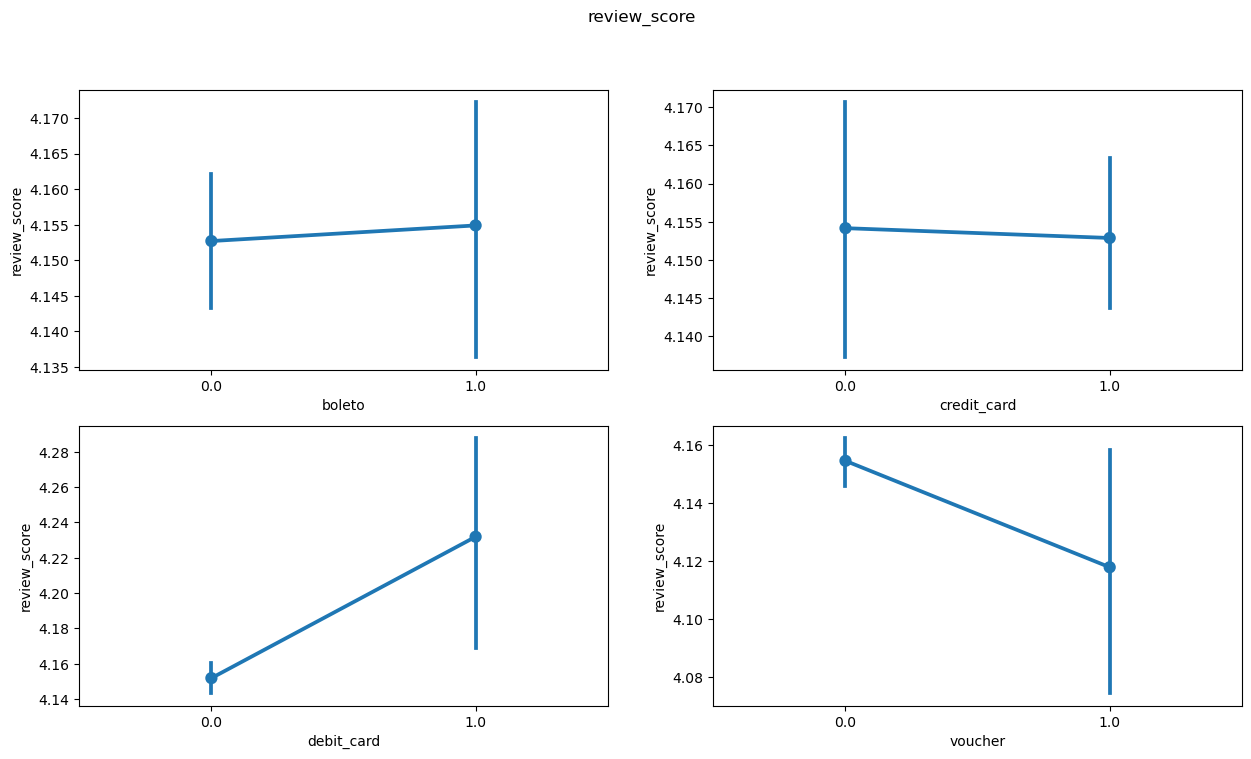

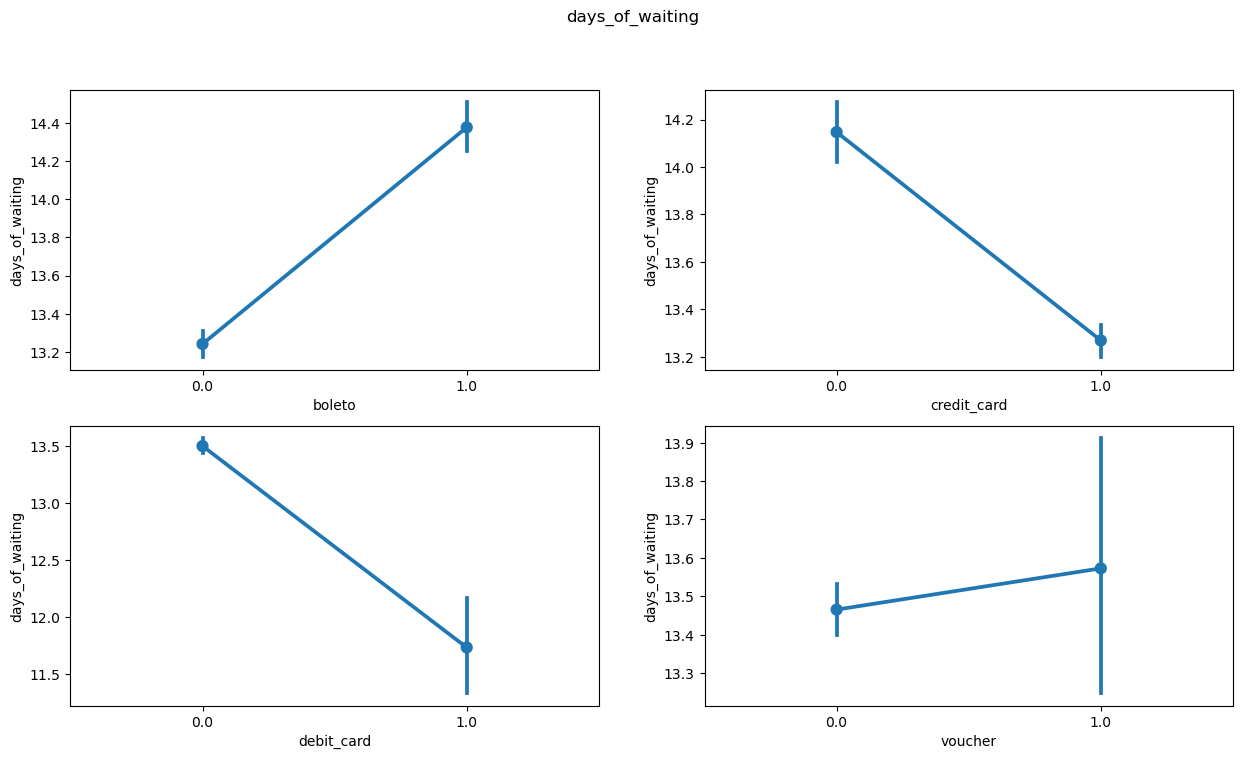

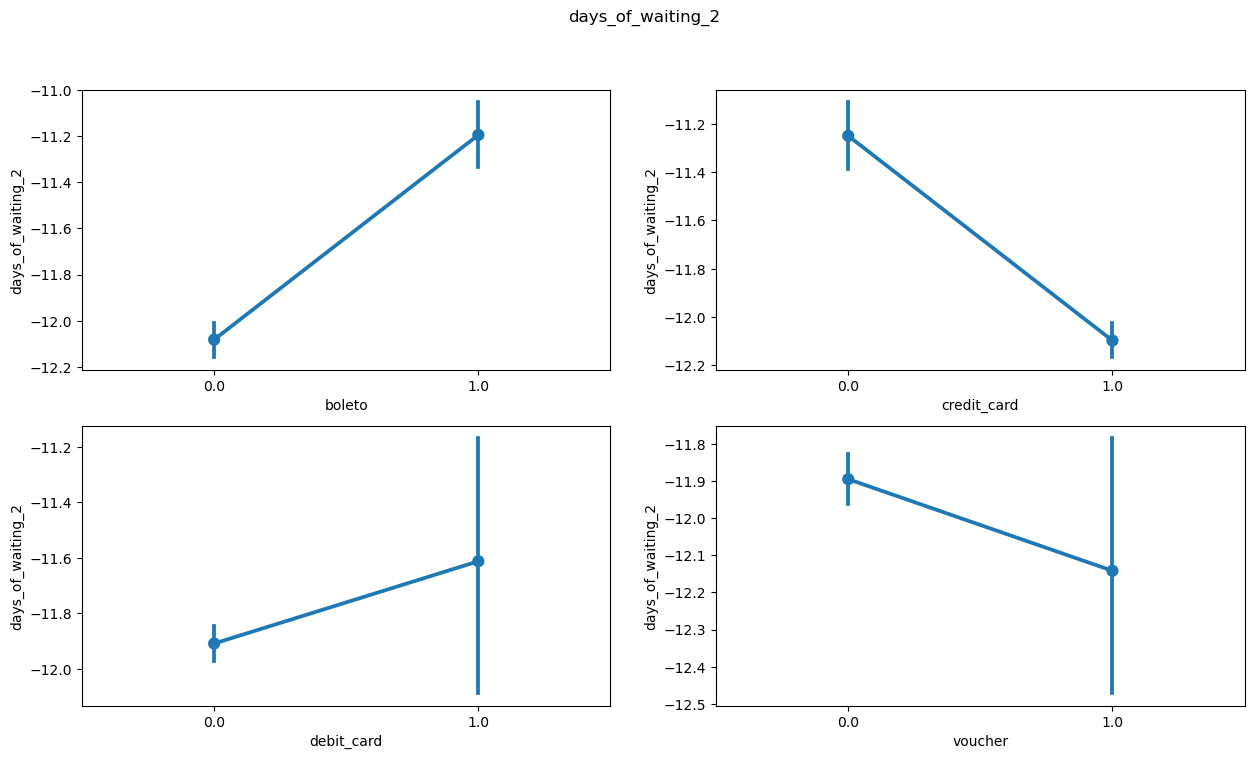

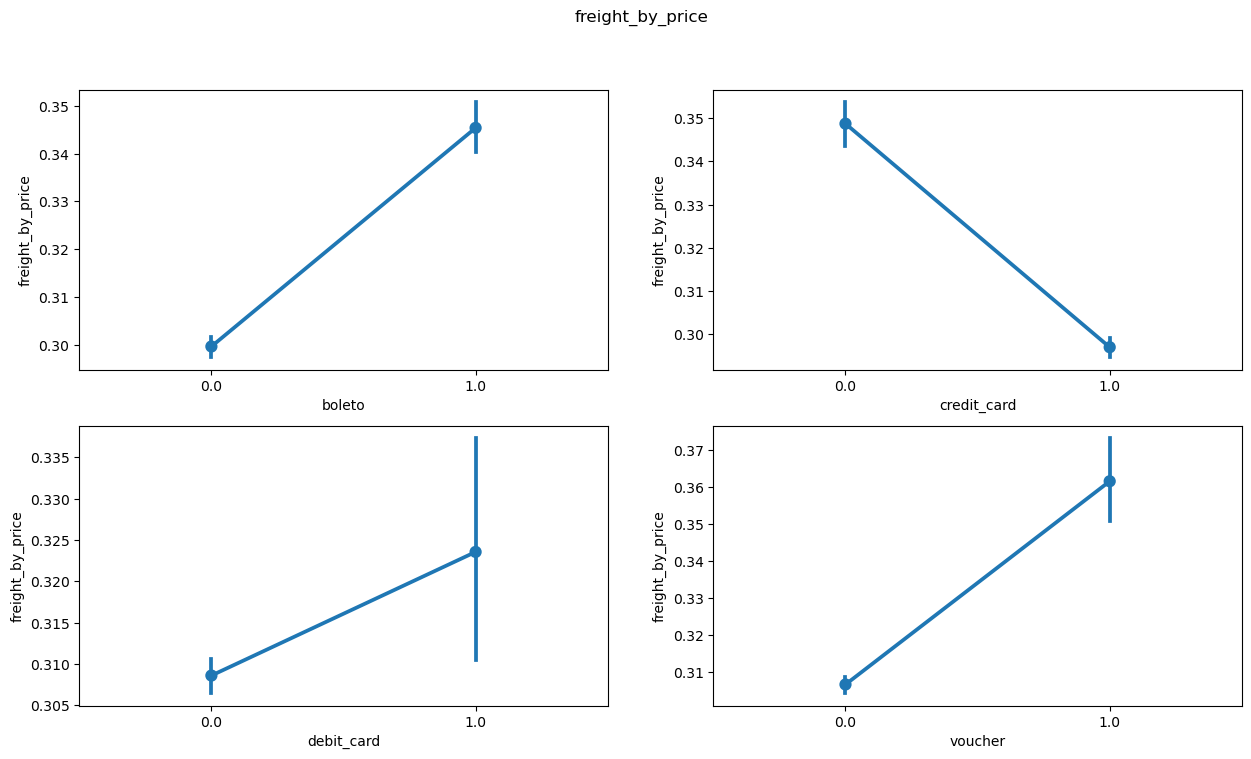

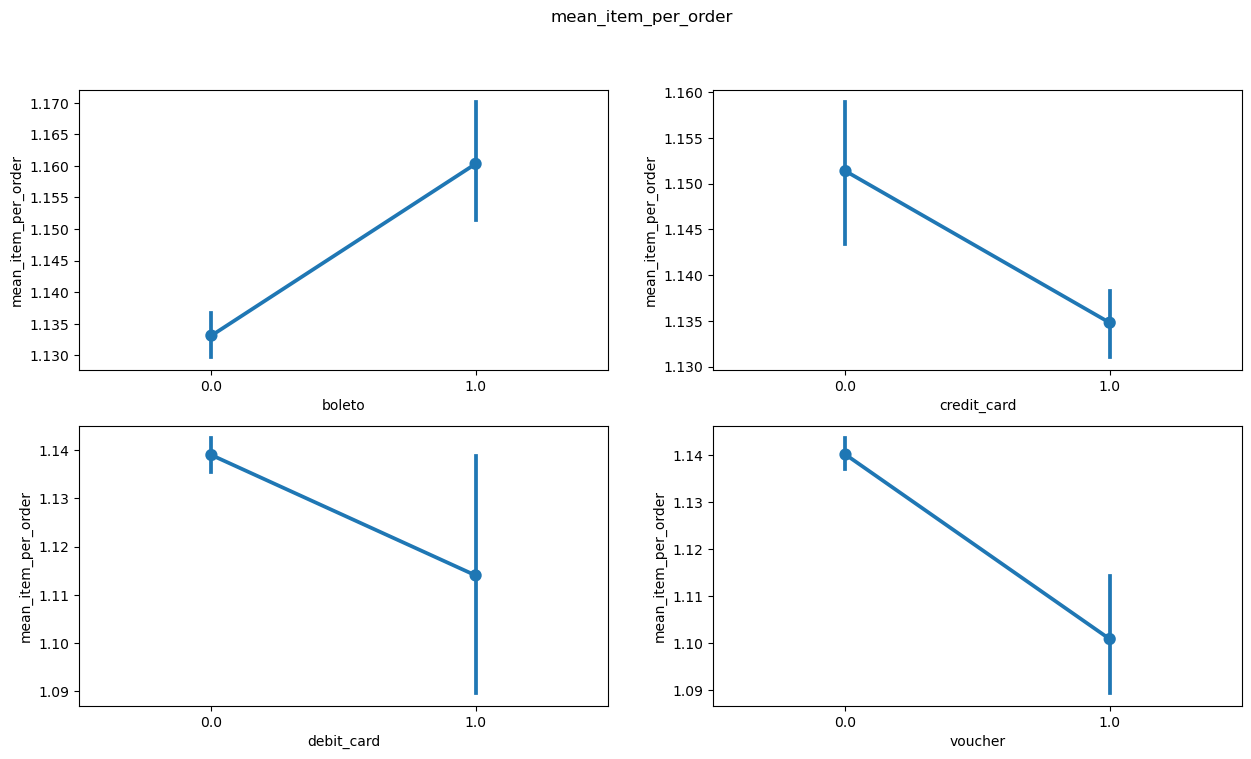

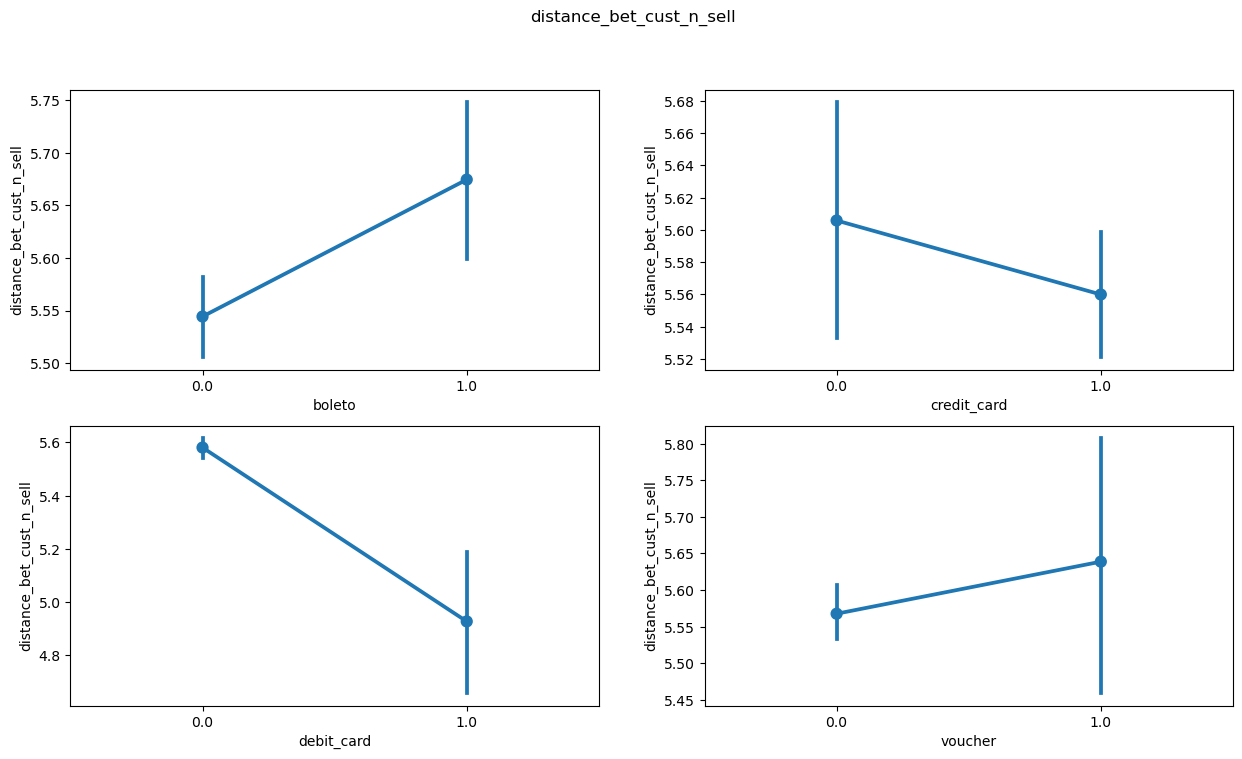

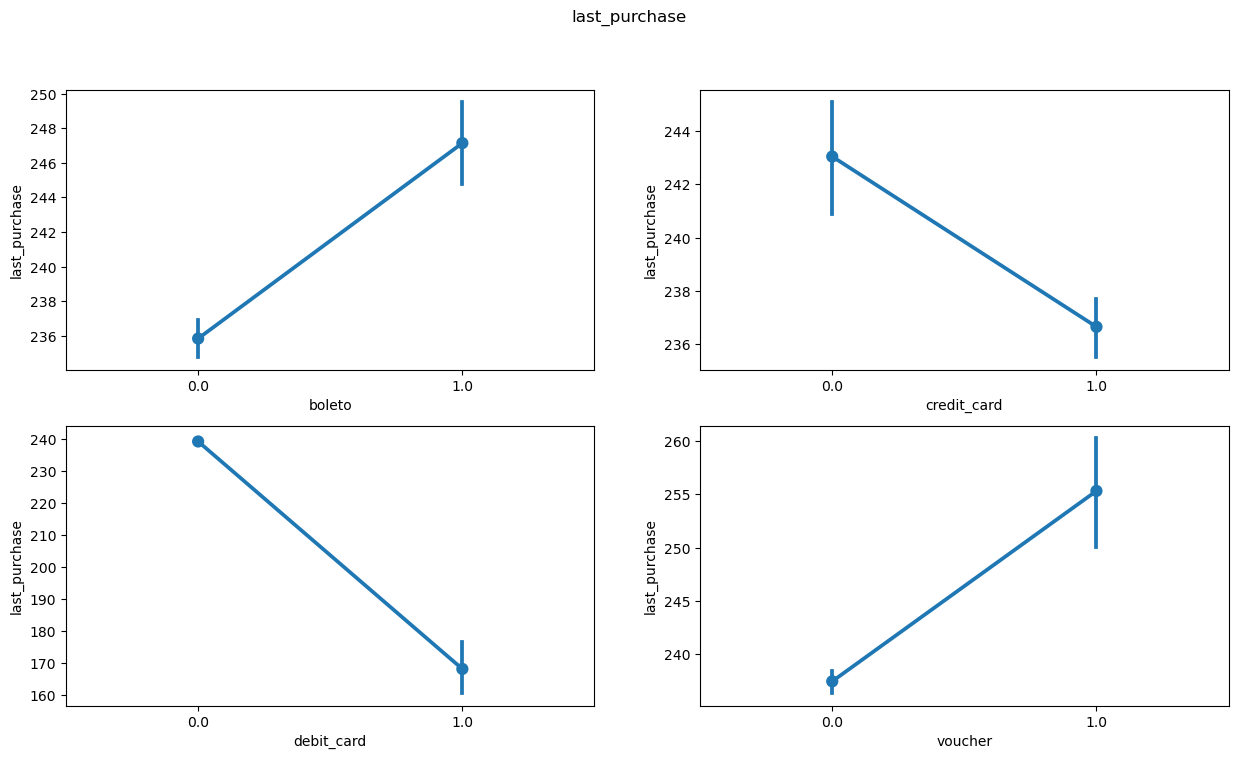

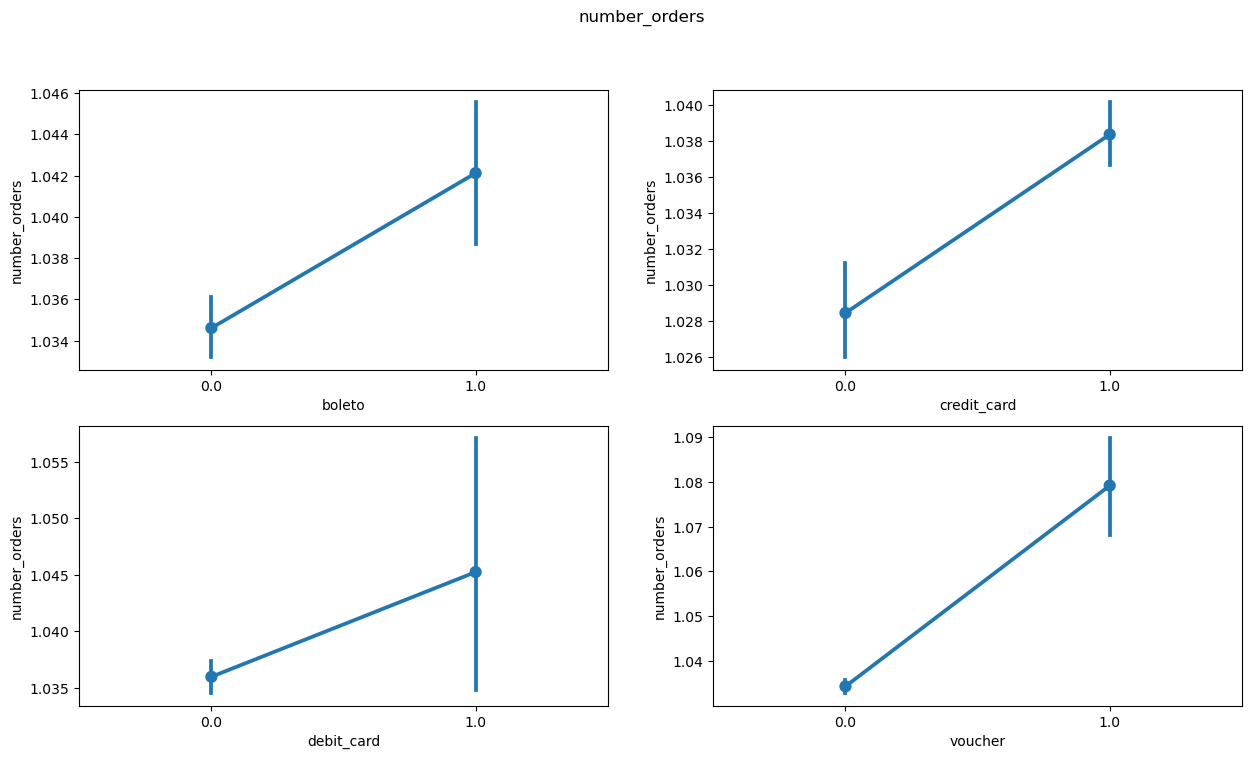

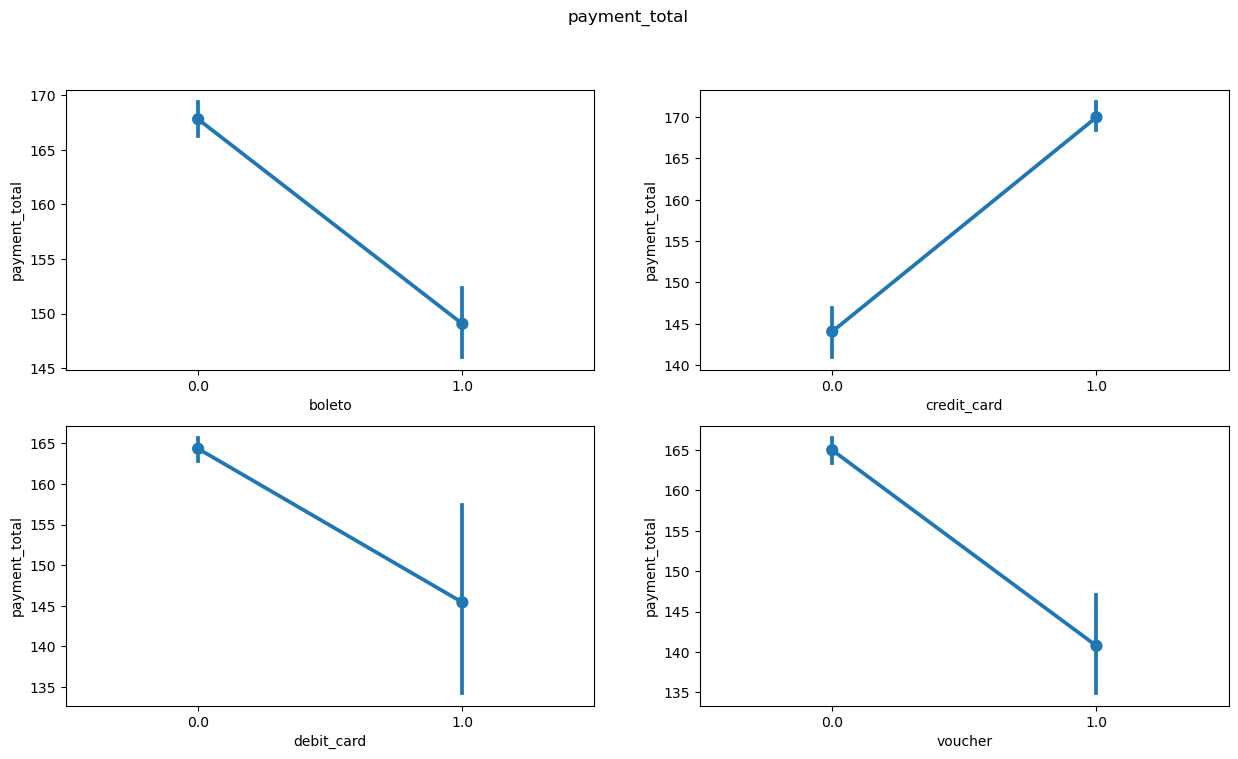

In [120]:
for feat in features:
    fig, axes = plt.subplots(2, 2, figsize=(15,8))
    for paiement, coordonnee in zip(type_paiement, coor):
        fig.suptitle(feat)
        sns.pointplot(data=data_base, x=paiement, y=feat, ax=axes[coordonnee])
        #axes[coordonnee].set_title(paiement)


## Analyse Multivariée

On décide de produire une ACP afin de construire nos axes principaux. Ces derniers nous permettrons de comprendre les grandes tendances de nos clients.

In [121]:
df

,review_score,days_of_waiting,days_of_waiting_2,geolocation_lat,geolocation_lng,freight_by_price,mean_item_per_order,boleto,credit_card,debit_card,voucher,distance_bet_cust_n_sell,last_purchase,number_orders,payment_total
customer_unique_id,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.661634,-0.683150,0.685482,-0.392908,-0.161428,-0.692307,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,-0.845150,-0.827446,-0.165264,-0.098858
0000b849f77a49e4a4ce2b2a4ca5be3f,-0.119650,-0.999937,0.685482,-0.422834,-0.148025,0.415039,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,-1.007358,-0.807762,-0.165264,-0.610925
0000f46a3911fa3c0805444483337064,-0.900934,1.428767,0.983339,-1.147564,-0.605324,-0.189601,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,-0.153456,1.967583,-0.165264,-0.347414
0000f6ccb0745a6a4b88665a16c9f078,-0.119650,0.795192,-0.009519,3.535170,-0.545741,1.181679,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,3.093300,0.550385,-0.165264,-0.537581
0004aac84e0df4da2b147fca70cf8255,0.661634,0.056021,0.387624,-0.413655,-0.315738,-0.687655,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,-0.755369,0.333869,-0.165264,0.146618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.661634,1.639958,-1.498807,2.296712,2.388347,0.038664,1.651146,-0.501145,0.544399,-0.126371,-0.199907,2.358443,1.377084,-0.165264,8.496683
fffea47cd6d3cc0a88bd621562a9d061,-0.119650,1.851150,0.884053,1.599995,1.794428,-0.017312,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,1.565767,0.163281,-0.165264,-0.354735
ffff371b4d645b6ecea244b27531430a,0.661634,0.267213,-1.796665,1.670194,-2.310946,-0.185187,-0.265622,-0.501145,0.544399,-0.126371,-0.199907,1.583924,2.170977,-0.165264,-0.230279


In [122]:
X = df[['last_purchase', 'payment_total', 'days_of_waiting',
   'freight_by_price', 'mean_item_per_order', 'distance_bet_cust_n_sell', 'mean_item_per_order', 'review_score']] #'mean_item_per_order', review_score

In [123]:
pca = PCA(n_components=3)

#On produit un ACP sur les données normalisées
pca.fit(X)

PCA(n_components=3)

In [124]:
#Combien de variance est expliquée par chacun de nos 2 axes ?
pca.explained_variance_ratio_

array([0.26324065, 0.20061414, 0.15568071])

In [125]:
pca.explained_variance_ratio_.cumsum()

array([0.26324065, 0.46385479, 0.61953551])

In [126]:
pcs = pca.components_ 
pcs = pd.DataFrame(pcs)
pcs.columns = X.columns
pcs.index = [f"F{i}" for i in range(0,3)]
pcs.round(2)

,last_purchase,payment_total,days_of_waiting,freight_by_price,mean_item_per_order,distance_bet_cust_n_sell,mean_item_per_order,review_score
F0,0.01,0.24,0.07,0.05,0.67,0.05,0.67,-0.19
F1,0.16,0.00,0.65,0.26,-0.12,0.56,-0.12,-0.38
F2,-0.07,-0.65,-0.15,0.71,0.11,-0.00,0.11,0.12


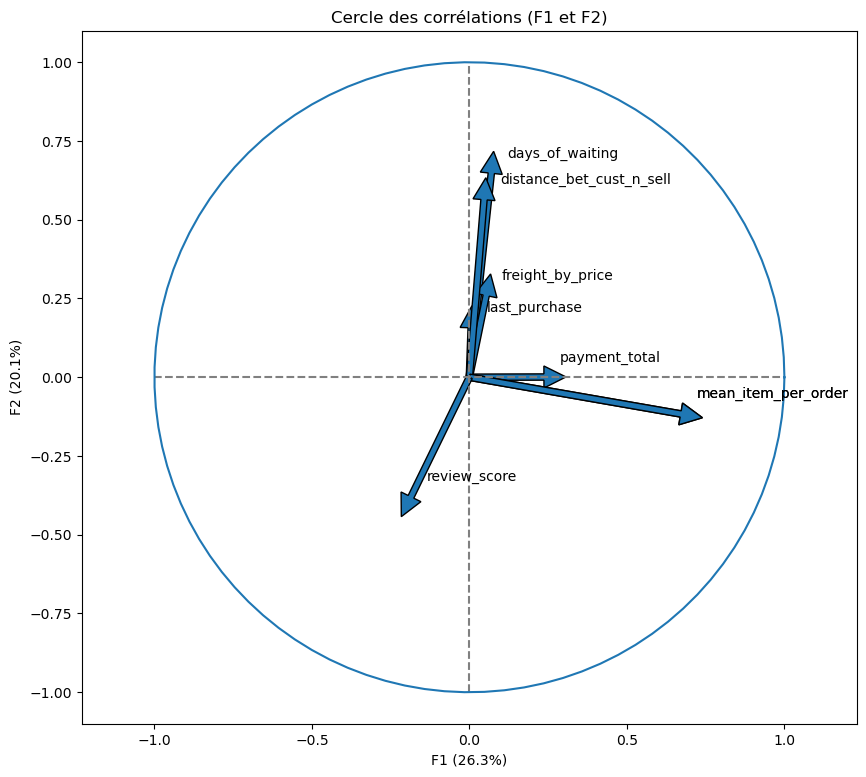

In [127]:
#On affiche le cercle de corrélation
x_y = (0,1)
correlation_graph(pca, x_y, pcs.columns)

Les 2 premiers axes principaux sont construit de la manière suivante : 
- Le 1er est corrélé aux nombres moyens d'articles par commandes et au paiement total. Il décrit donc globalement l'investissement des clients.
- Le 2ème est corrélé aux nombres de jours d'attentes, à la distance moyenne entre chaque client et ses vendeurs, au rapport frêt par le prix et anticorrélé à la note moyenne des clients. Il décrit donc la qualité de la livraison.

In [128]:
#Projection des variables 
X_proj = pca.transform(X)

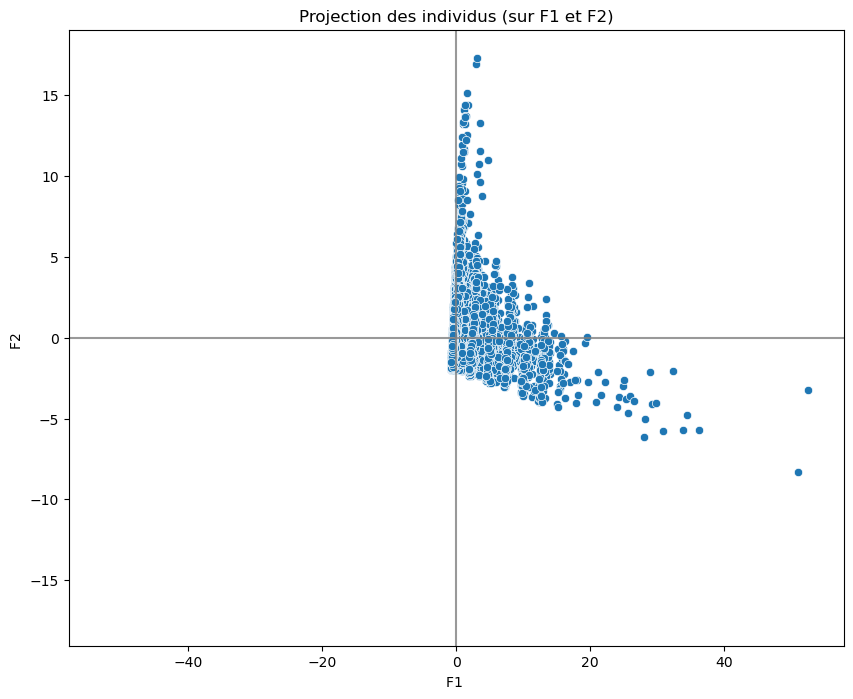

In [129]:
x_y = [0,1]
display_factorial_planes(X_proj, x_y)

On observe que les clients ont une satisfaction globalement assez proche avec tout de même un certains nombre ayant peu apprécié le service. De plus, l'ensemble des clients a un investissement assez faible, c'est-à-dire qu'ils commandent peu de fois et que les commandes sont rarement composées de plusieurs articles. On dénote néanmoins une minorité (probablement venant des 3% des clients les plus investit sur le site) d'individu ayant une grande consommation.

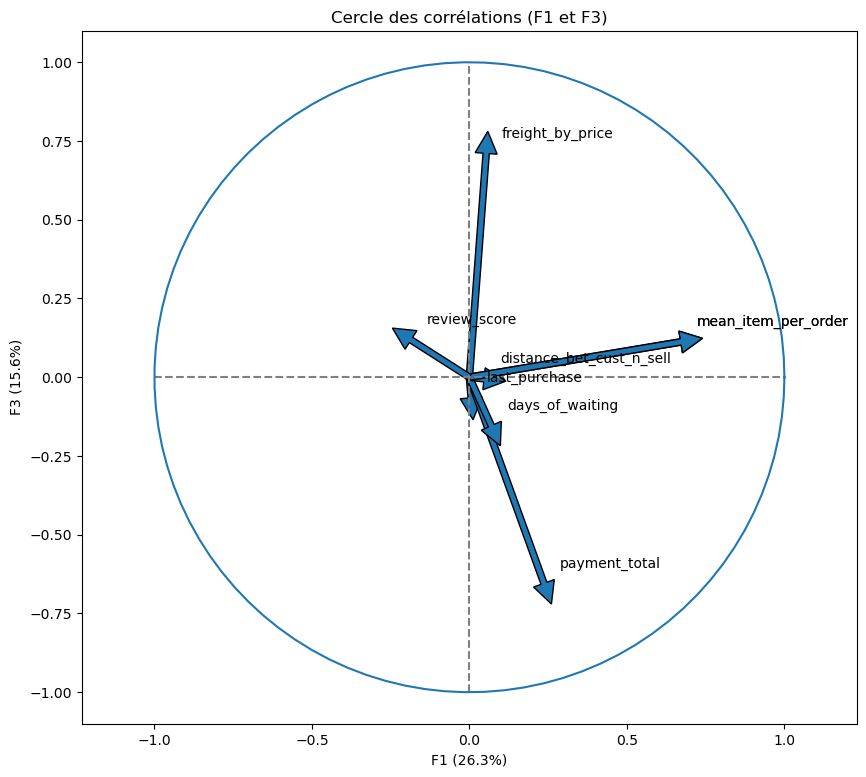

In [130]:
#On affiche le cercle de corrélation
x_y = (0,2)
correlation_graph(pca, x_y, pcs.columns)

Le deuxième plan factoriel est décrit de la manière suivante :
- Le 1er axe principal est corrélé au nombre moyen d'article par commande et légèrement anticorrélé à la note moyenne. Il décrit donc l'exigence des clients.
- Le 3ème axe principal est corrélé au rapport fret par prix et anticorrélé à la valeur totale de paiement. Il décrit donc la rentabilité du client sur ses commandes. (Dans le sens ou plus il prends de grosse commande, plus le coût du fret sera petit relativement au prix total).

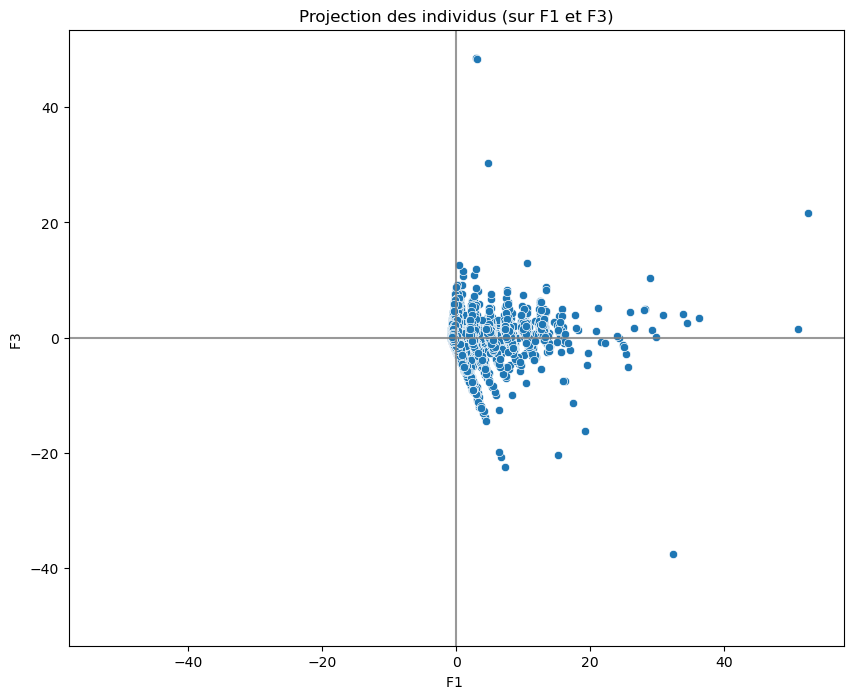

In [131]:
x_y = [0,2]
display_factorial_planes(X_proj, x_y)

On remarque une légère corrélation positive entre le niveau d'exigence des clients ainsi que leurs rentabilités.

# Extraction des dataframes

## RFM

### DataFrame normalisé

In [132]:
#On exporte notre dataframe data en 'data_traitement.csv'
rfm_scaled[['last_purchase', 'number_orders', 'payment_total']].to_csv("rfm_scaled.csv", index=False)

### DataFrame non normalisé

In [133]:
rfm[['last_purchase', 'number_orders', 'payment_total']].to_csv("rfm.csv", index=False)

## Toute les variables

### DataFrame normalisé

In [134]:
df.to_csv('data.csv', index=False)

### DataFrame non normalisé

In [135]:
data_base.to_csv('data_no_scaled.csv', index=False)

In [136]:
data_base.to_csv('df.csv', index=True)